<a href="https://colab.research.google.com/github/bernarducs/code_chunks/blob/master/Projeto_S%C3%A9ries_Temporais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Detalhes do projeto

1 - Escolha uma ou duas bases de dados;

2 - Se necessário, faça um pré-processamento;
  - Analise as características da série temporal;
  - Utilize a Função de Auto-Correlação (FAC) e Função de Auto-Correlação Parcial (FACP)   

3 - Aplique um, ou dois métodos de previsão de série temporal:
  - Usar ARIMA, MLP e K-NN
  - Se escolher uma série temporal, utilize três métodos de previsão;
  - Se escolher duas série temporal, utilize dois métodos de previsão (ARIMA e MLP);

4 - Divida a série temporal em 50% treinamento, 25% validação e 25% teste para modelos de Machine Learning;
 - Divida a série temporal em 75% treinamento e 25% teste para o modelo ARIMA;

5 - Faça uma análise de sensibilidade dos parâmetros dos algoritmos utilizando o conjunto de validação (no caso das técnicas de Machine Learning);

6 - A partir da análise de sensibilidade, encontre os melhores parâmetros para cada método de previsão;

7 - Gere os resultados para o conjunto de teste;

8 - Compare os resultados a partir de duas, ou mais medidas de avaliação;
 - Sugestão: MSE, MAPE, POCID e MAE*

9 - Plote a previsão x série real

10 - Discuta qual o algoritmo que você escolheria para a base de dados analisada. 

OBS: Dividir o os dados em conjuntos de treinamento e teste, ou treinamento, validação e teste (se for necessário).

### Vehicle

Fonte: https://raw.githubusercontent.com/EraylsonGaldino/dataset_time_series/master/vehicle.txt

### Pacotes

In [251]:
# dados
import itertools
import numpy as np
import pandas as pd

In [252]:
# visualização
import matplotlib.pyplot as plt
import seaborn as sns;

In [253]:
# series temporais
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller  # teste de estacionariedade
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [254]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error as MSE

## Preparação

### Dataset

In [255]:
df = pd.read_csv('https://raw.githubusercontent.com/EraylsonGaldino/dataset_time_series/master/vehicle.txt', names=['freq'])
df.head(3)

,freq
0,4.367
1,5.147
2,5.418


Temos 252 linhas no dataset. Como não sabemos as datas reais do dataset vamos arbitrar um intervalo temporal com intervalo de 252 períodos.

In [256]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   freq    252 non-null    float64
dtypes: float64(1)
memory usage: 2.1 KB


In [257]:
df.index = pd.date_range(start='1/1/2000', periods=len(df))

In [258]:
df.index.dtype

dtype('<M8[ns]')

### Características da Série

Plotando a série vemos que ela não é estacionária.

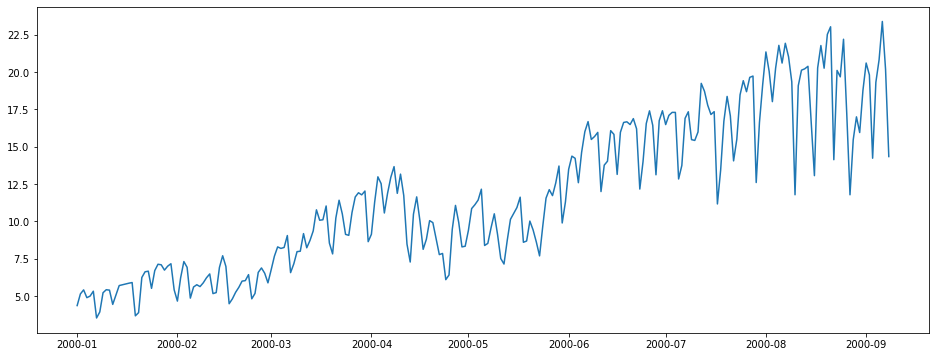

In [259]:
plt.figure(figsize=(16, 6))
plt.plot(df);

Dando 'zoom' nos úlitmos 24 períodos para observar a presença de ciclos.

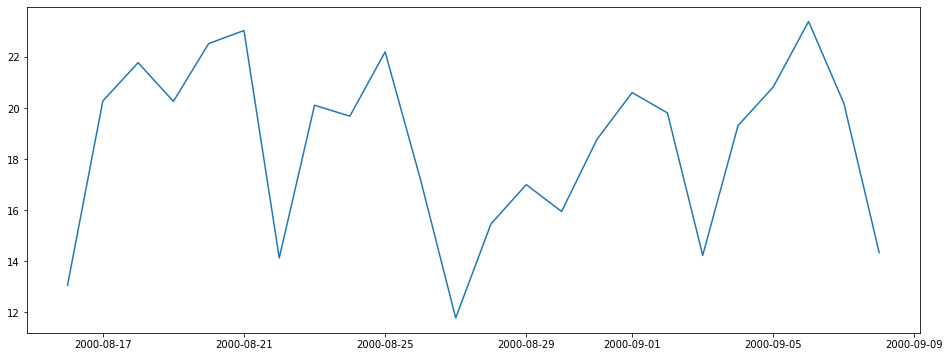

In [260]:
plt.figure(figsize=(16, 6))
plt.plot(df.tail(24));

Usando *seasonal_decompose* do statsmodel fica mais clara a sazonalidade, com intervalo de 6 períodos.

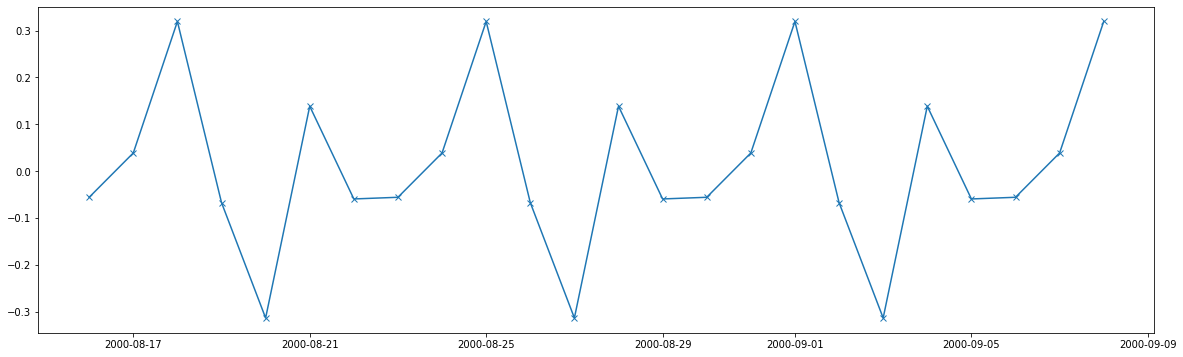

In [261]:
plt.figure(figsize=(20, 6))
decomp = seasonal_decompose(df)
plt.plot(decomp.seasonal[-24:], 'x-');

Plotando todos os tipos de decomposição vemos também que a tendência e o ruído aumenta com o passar do tempo.

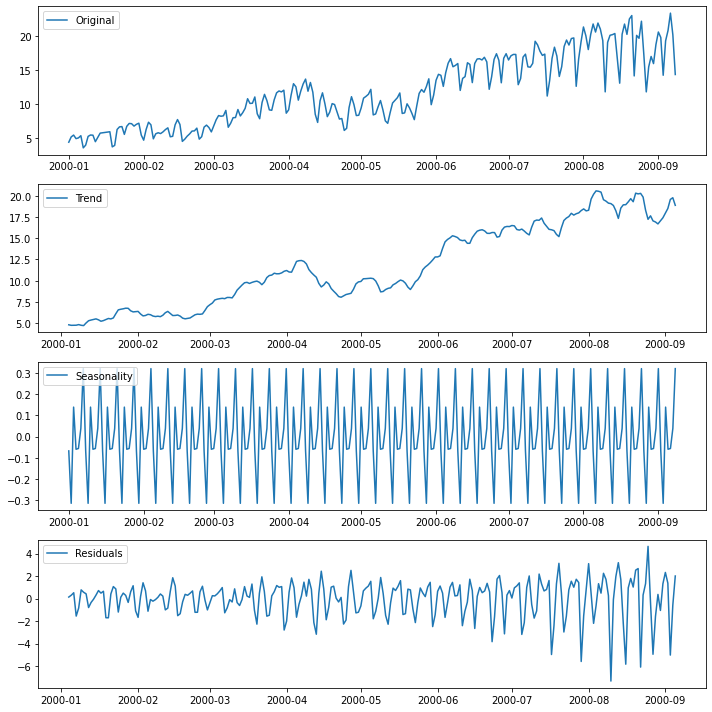

In [262]:
tendencia = decomp.trend
sazonalidade = decomp.seasonal
residuo = decomp.resid

plt.figure(figsize=(10, 10))
plt.subplot(411)
plt.plot(df, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(tendencia, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(sazonalidade,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residuo, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### Treino e teste

In [355]:
n_dados_teste = int(len(df) * 0.25)
n_dados_teste

63

In [356]:
treino, teste = df[:-n_dados_teste], df[-n_dados_teste:]

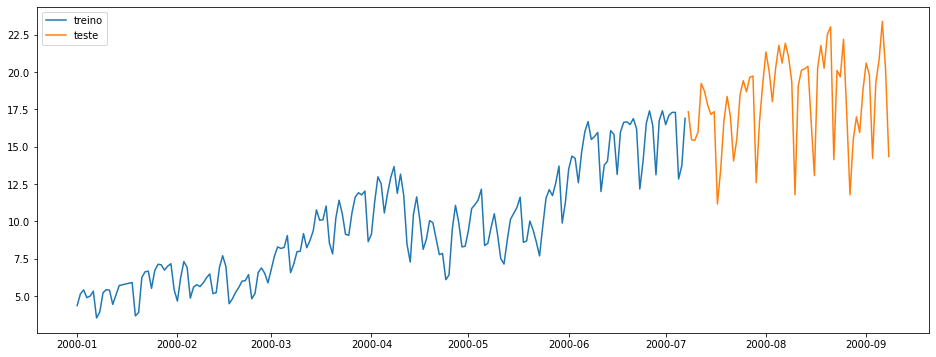

In [357]:
plt.figure(figsize=(16, 6))
plt.plot(treino, label='treino')
plt.plot(teste, label = 'teste')
plt.legend(loc= 'best');

## ARIMA e SARIMAX

### Série estacionária

Já com os dados de treino vamos diferenciar nossa série em 6 períodos como identificamos logo acima.

In [358]:
treino['6diff'] = treino.diff(6)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [359]:
def teste_df(serie, valor_critico=10):
    #H0: série não estacionária 
    dftest = adfuller(serie, autolag='AIC')
    df_output = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags','Nº Observações'])
    for key, value in dftest[4].items():
        df_output['Valor Crítico (%s)'%key] = value
    print(df_output)
    if df_output[0] < df_output[f"Valor Crítico ({valor_critico}%)"]: # descarta a H0 se o teste estatistico for menor que o valor crítico 
        
        print('--------estacionária')
    else:
        print(df_output[0])
        print('--------não estacionária')

Nossa diferenciação nos retornou estacionariedade com valor crítico de 5%.

In [360]:
teste_df(treino['6diff'].dropna(), 5)

Test Statistic          -2.989021
p-value                  0.035932
#Lags                    6.000000
Nº Observações         176.000000
Valor Crítico (1%)      -3.468062
Valor Crítico (5%)      -2.878106
Valor Crítico (10%)     -2.575602
dtype: float64
--------estacionária


Mas não para 1%

In [361]:
teste_df(treino['6diff'].dropna(), 1)

Test Statistic          -2.989021
p-value                  0.035932
#Lags                    6.000000
Nº Observações         176.000000
Valor Crítico (1%)      -3.468062
Valor Crítico (5%)      -2.878106
Valor Crítico (10%)     -2.575602
dtype: float64
-2.98902121143043
--------não estacionária


### Encontrando parâmetros para ARIMA

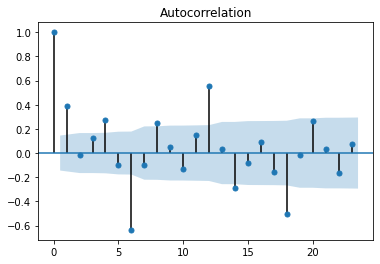

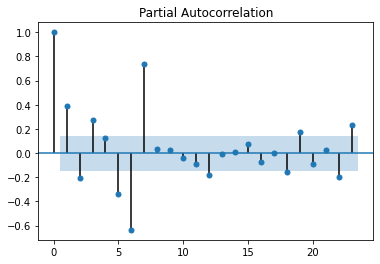

In [362]:
plot_acf(treino['6diff'].dropna());
plot_pacf(treino['6diff'].dropna());

In [385]:
arima_params = (3, 1, 1)

In [386]:
model_arima = ARIMA(treino['freq'].values, order=arima_params).fit()

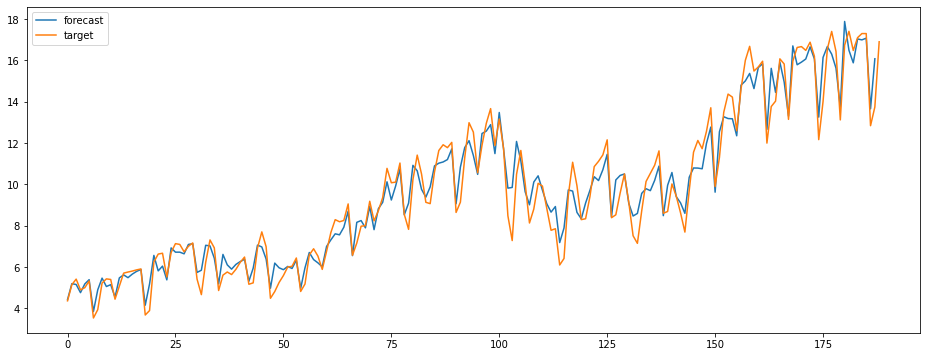

In [387]:
plt.figure(figsize=(16, 6))
plt.plot(model_arima.predict(typ='levels'), label = 'forecast')
plt.plot(treino.freq.values, label = 'target')
plt.legend()
plt.show()

### Testando o modelo

Como o Arima captura as relações lineares em seu modelo, observamos abaixo o resultado parecido com uma linha de tendência...

In [389]:
predito_arima = model_arima.predict(start=190, end=252, typ='levels')

In [390]:
previsao_arima = model_arima.forecast(len(teste))

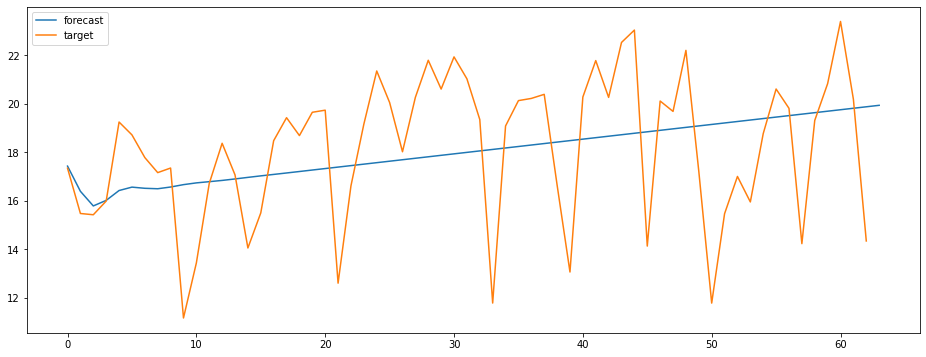

In [391]:
plt.figure(figsize=(16, 6))
plt.plot(predito_arima, label = 'forecast')
plt.plot(teste.freq.values, label = 'target')
plt.legend()
plt.show()

...já com SARIMAX (para realizar SARIMA, já que não estaos complementndo com uma série exógena) temos a captação de boa parte dos ciclos característicos da série.

In [392]:
sarima_params = (*arima_params, 6)

In [393]:
model_sarimax = SARIMAX(
    endog=treino['freq'].values, order=arima_params, seasonal_order=sarima_params).fit()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:981: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [394]:
previsao_sarima = model_sarimax.forecast(len(teste))

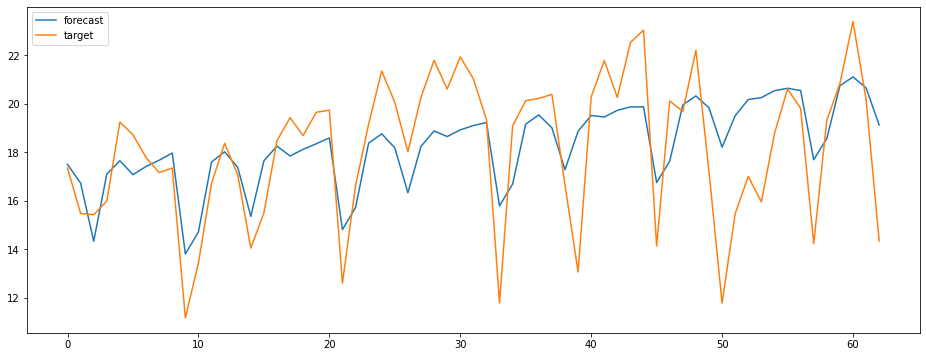

In [395]:
plt.figure(figsize=(16, 6))
plt.plot(previsao_sarima, label = 'forecast')
plt.plot(teste.freq.values, label = 'target')
plt.legend()
plt.show()

## Multlayer Perceptron (MLP)

No modelo arima fizemos a análise de autocorrelação e parcial-autocorrelação depois que a tornamos estacionária. Para MLP não há necessidade de passo prévio. Usamos autocorrelação aqui para estimar a quantidade de janelas de acordo com quantos lags estão em correlação com o registro de referência.

Abaixo temos uma janela para 18 lags.

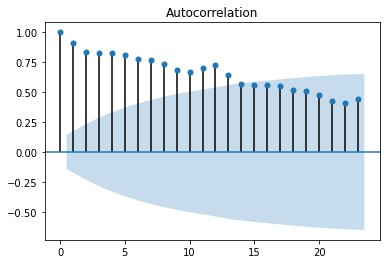

In [373]:
plot_acf(treino.freq);

### Janelas deslizantes (sliding windows)

In [374]:
def create_sliding_windows(series, window_size):
   
    list_of_sliding_windows = []
    list_size_to_iterate = len(series) - window_size 
    for i in range(0, list_size_to_iterate):
        window = series[i: i + window_size + 1]
        list_of_sliding_windows.append(window)

    return np.array(list_of_sliding_windows).reshape(len(list_of_sliding_windows), window_size + 1)

Dataset de treino com as janelas

In [375]:
windows_train = create_sliding_windows(treino.freq.values, 18)
windows_train.shape

(171, 19)

### Dados de validação

Vamos retirar 20% do dataset de treino para formar um de avaliação. Para darmos um estimativa prévia do aprendizado do modelo.

In [376]:
perc_val = 0.2
tam_val = np.fix(len(windows_train) *perc_val).astype(int)

X_train, y_train = windows_train[0:-tam_val, 0:-1], windows_train[0:-tam_val, -1]
X_val, y_val = windows_train[-tam_val:, 0:-1], windows_train[-tam_val:, -1]

In [377]:
print('X treino:', X_train.shape, '\t', 'y treino:', y_train.shape)
print('X validação:', X_val.shape, '\t', 'y validação:', y_val.shape)

X treino: (137, 18) 	 y treino: (137,)
X validação: (34, 18) 	 y validação: (34,)


Fazendo o mesmo para o dataset de teste mas com uma observação: vamos resgatar os 18 registros anteriores aos dados de teste a fim de obtermos dados das janelas para cada outpout do dataset de teste.

In [378]:
# resgatando os 18 pré aos dataset de teste
pontos_anteriores_test = teste.freq.values[-18:]
test = np.hstack([pontos_anteriores_test, teste.freq.values])

# gerando janelas e dividindo entre inputs e outputs
windows_test = create_sliding_windows(test, 18)
X_test, y_test = windows_test[:, 0:-1], windows_test[:, -1]

In [379]:
print('X teste:', X_test.shape, '\t', 'y teste:', y_test.shape)

X teste: (63, 18) 	 y teste: (63,)


Invertando as ordens das matrizes na vertical. Assim o lag1, lag2 que estavam na extrema direita passam para índice 0, 1, 2... de cada linha do array

In [380]:
X_train_ajus = np.flip(X_train, 1)
X_val_ajus = np.flip(X_val, 1)
X_test_ajus = np.flip(X_test, 1)

### Modelo

Abaixo temos aplicação de grid search que nos dará o melhor modelo entre diversas combinações de parâmetros utilizadas pelo regressor MPL (`MPLRegressor`).

Treinamos varios conjuntos de neurônios, funcões de ativação, algoritmo de treinamento e taxa de aprendizado, criando um modelo com dados de teste por iteração (`mpl.fit`) e avaliando com os resultados de validação (`mpl.predict`), através do menos erro médio ao quadrado (`MSE`).

Executamos algumas vezes (`num_exec`) para minimizar resultados aleatórios.

In [381]:
def treinar_mlp(x_train, y_train, x_val, y_val, num_exec):
  neuronios = [10, 15, 18, 20]#, 20, 30, 40, 50]#, 60, 70, 80, 90, 100, 120, 150, 170, 200]
  func_activation = ['relu']#, 'tanh'] 
  alg_treinamento = ['lbfgs']#, 'sgd', 'adam']
  max_iteracoes = [10000]
  learning_rate = ['adaptive', 'invscaling']
  num_exec = list(range(0, num_exec))

  tup = (neuronios, func_activation, alg_treinamento, max_iteracoes, learning_rate, num_exec)

  best_result = np.Inf
  for i, j, l, m, n, e in itertools.product(*tup):

    mlp = MLPRegressor(
          hidden_layer_sizes=i, activation=j, solver=l, max_iter=m, learning_rate=n
          )
    mlp.fit(x_train, y_train)

    predict_validation = mlp.predict(x_val)  
    mse = MSE(y_val, predict_validation)
    print(mse)
    if mse < best_result:
        best_result = mse
        select_model = mlp
  
  print('Modelo escolhido:\n', select_model, 'MSE:', best_result, '\n')
  return select_model

0.861551646519543
1.1051144120432546
0.7888508729180207
1.2313760987922777
1.0220062780452117
0.7345983113191152
0.8301179646114294
0.8402143851239616
0.6897059009019942
0.7898867345970375
0.7906170267892259
1.3711647496092605
0.7903686257109676
0.7896572573366579
0.776811869496307
0.8726772717590423
0.7156651574303535
1.0682183155229505
0.7905963534371683
0.7891712420379031
1.2893063936998337
0.7869616869461771
0.821143315077637
0.7902513288032076
0.790578794457398
0.5882275055502761
0.7917741375555674
0.6854816758795428
0.7903389277828055
0.7113225384755218
0.8028048344753235
0.7870527365607447
1.6050839120197706
1.0637805155992464
0.8768577953993113
0.9566703545338384
0.8186431455756078
0.8657379509225467
0.790919986811023
0.7831668648187923
0.7890891012307413
0.7742231803904955
0.7871275317297507
1.620632428281991
0.7728902577700016
0.7906908063343305
1.23241898503283
0.797696318482969
1.5967030820035006
0.968791324345004
1.03471679127206
0.8925883330488166
0.7906208484805459
0.697

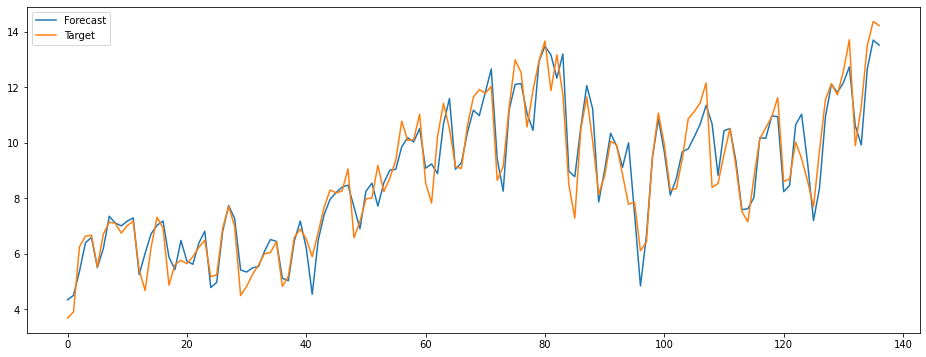

In [382]:
modelo =  treinar_mlp(X_train, y_train, X_val, y_val, 30)
trainPredict = modelo.predict(X_train)

plt.figure(figsize=(16, 6))
plt.plot(trainPredict, label='Forecast')
plt.plot(y_train, label='Target')
plt.legend()
plt.show()

### Testando o modelo

Com o melhor modelo selecionado usaremos nos dados de teste.

In [383]:
testPredict = modelo.predict(X_test)

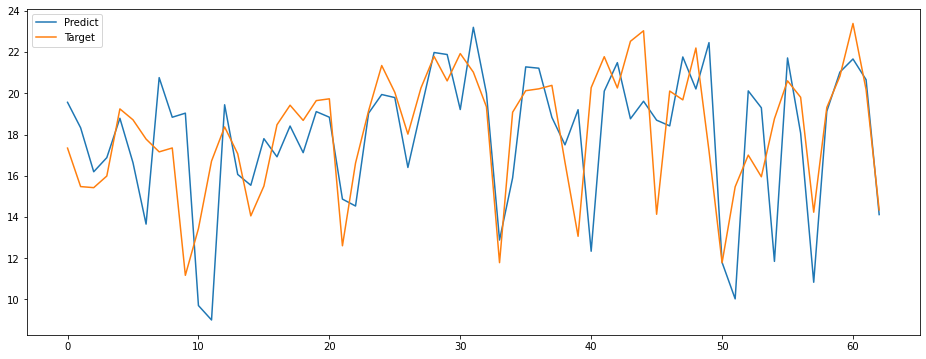

In [384]:
plt.figure(figsize=(16, 6))
plt.plot(testPredict, label = 'Predict')
plt.plot(y_test, label= 'Target')
plt.legend()
plt.show()